## Preparation

In [94]:
# Library imports
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
import numpy as np
# http://stat-computing.org/dataexpo/2009/the-data.html

About the following imports:
* _airports_ contains coordinates for airports in the USA.
* _carriers_ contains airport names and cities that are useful for data merging and indexing.
*

In [97]:
# Data imports (files attached in the email assignment)
carriers  = pd.read_excel('Data/carriers.xls')
carriers.columns = ['UniqueCarrier','Description']
carriers.dropna(how="all", inplace=True) 
codes = pd.read_csv('Data/airport_codes.csv') # Data from http://www.airportcodes.us/us-airports.htm
codes = codes.set_index('Code').to_dict()
airports  = pd.read_excel('Data/airports new.xlt')
airports = airports.query("country=='USA'")
airports.head()

iata               airport              city state country        lat  \
0  00M              Thigpen        Bay Springs    MS     USA  31.953765   
1  00R  Livingston Municipal        Livingston    TX     USA  30.685861   
2  00V           Meadow Lake  Colorado Springs    CO     USA  38.945749   
3  01G          Perry-Warsaw             Perry    NY     USA  42.741347   
4  01J      Hilliard Airpark          Hilliard    FL     USA  30.688012   

         long  
0  -89.234505  
1  -95.017928  
2 -104.569893  
3  -78.052081  
4  -81.905944

## Basic exploration

Just out of curiosity, I plotted the number of airports in each State. There are big states with not that many airports, and smaller states with a large amount of airports.

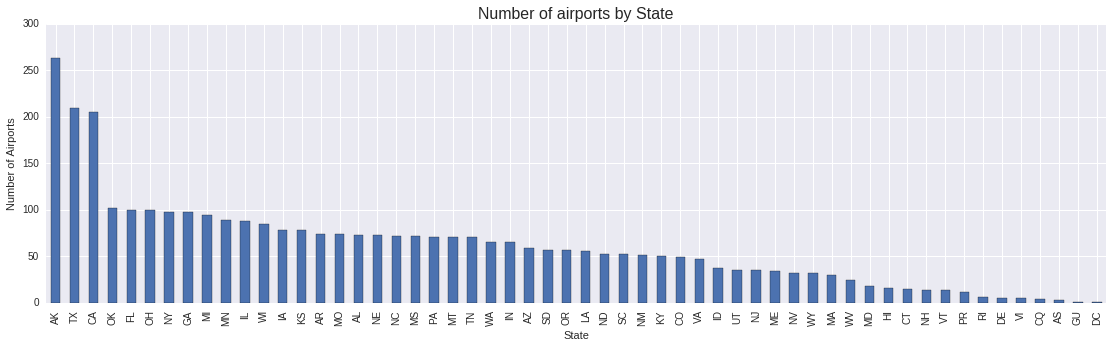

In [95]:
# Just o
plt.figure(figsize=(19,5))
airports.state.value_counts().plot(kind='bar')
plt.title('Number of airports by State',fontsize=16)
plt.xlabel('State')
plt.ylabel('Number of Airports')

Again, out of curiosity, I plotted the distribution of our airports in question. It follows the known patterns in US American geography and political divisions.

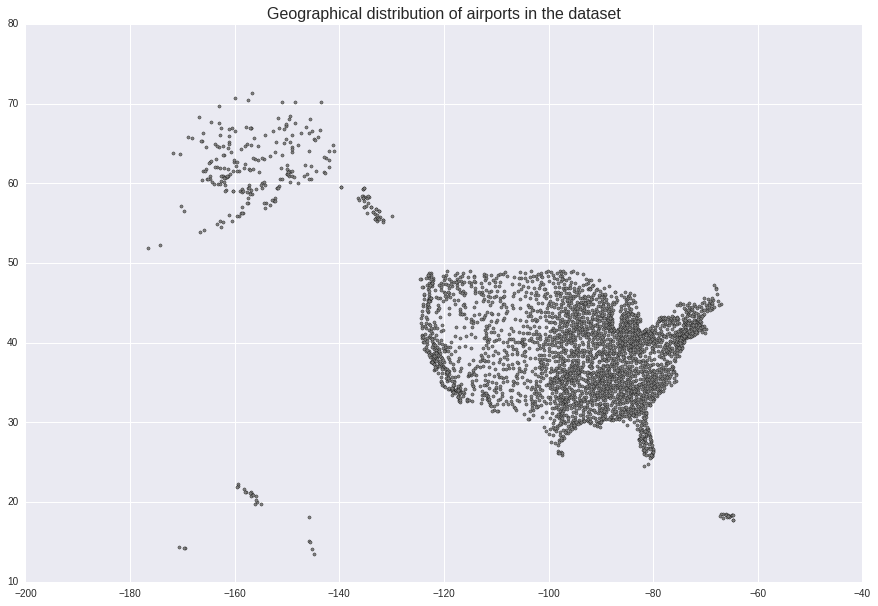

In [93]:
plt.figure(figsize=(15,10))
plt.scatter(airports.long,airports.lat,s=10,c='grey')
plt.title('Geographical distribution of airports in the dataset',fontsize=16)
plt.show()

For the centrality index I will only be working with 2008 data.

In [6]:
trips_08 = pd.read_csv('Data/trips/2008.csv')
trips_08.head()

Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  2008      1           3          4   2003.0        1955   2211.0   
1  2008      1           3          4    754.0         735   1002.0   
2  2008      1           3          4    628.0         620    804.0   
3  2008      1           3          4    926.0         930   1054.0   
4  2008      1           3          4   1829.0        1755   1959.0   

   CRSArrTime UniqueCarrier  FlightNum        ...         TaxiIn  TaxiOut  \
0        2225            WN        335        ...            4.0      8.0   
1        1000            WN       3231        ...            5.0     10.0   
2         750            WN        448        ...            3.0     17.0   
3        1100            WN       1746        ...            3.0      7.0   
4        1925            WN       3920        ...            3.0     10.0   

   Cancelled  CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
0          0               NaN         0           NaN          NaN      NaN   
1          0               NaN         0           NaN          NaN      NaN   
2          0               NaN         0           NaN          NaN      NaN   
3          0               NaN         0           NaN          NaN      NaN   
4          0               NaN         0           2.0          0.0      0.0   

   SecurityDelay  LateAircraftDelay  
0            NaN                NaN  
1            NaN                NaN  
2            NaN                NaN  
3            NaN                NaN  
4            0.0               32.0  

[5 rows x 29 columns]

In [7]:
print("The total number of flights was " + str(len(trips_08)) + " whereas the number of not cancelled trips was " +str(trips_08.Cancelled.value_counts()[0]) + ". The percentage of cancellation is " + str(100 - 100*trips_08.Cancelled.value_counts()[0] / len(trips_08)) + " %" )

The total number of flights was 7009728 whereas the number of not cancelled trips was 6872294. The percentage of cancellation is 1.96061815808 %


In the following lines I create a single data set with carriers, locations and trips:

In [8]:
data = trips_08.merge(carriers,on='UniqueCarrier')

Index([u'Year', u'Month', u'DayofMonth', u'DayOfWeek', u'DepTime',
       u'CRSDepTime', u'ArrTime', u'CRSArrTime', u'UniqueCarrier',
       u'FlightNum', u'TailNum', u'ActualElapsedTime', u'CRSElapsedTime',
       u'AirTime', u'ArrDelay', u'DepDelay', u'Origin', u'Dest', u'Distance',
       u'TaxiIn', u'TaxiOut', u'Cancelled', u'CancellationCode', u'Diverted',
       u'CarrierDelay', u'WeatherDelay', u'NASDelay', u'SecurityDelay',
       u'LateAircraftDelay', u'Description'],
      dtype='object')

In [10]:
data["origin_city"] = data["Origin"].map(codes['City'])
data["destin_city"] = data["Dest"].map(codes['City'])

In [11]:
# Average delays
delays = data.groupby(['origin_city','destin_city'])[['ArrDelay','DepDelay']].mean().reset_index()
delays['Total_delay'] = delays.ArrDelay+delays.DepDelay
delays.head()

origin_city destin_city  ArrDelay   DepDelay  Total_delay
0      Abilene      Dallas  5.037490   6.880397    11.917888
1  Adak Island   Anchorage  4.532609  13.652174    18.184783
2    Aguadilla    New York -0.175038   0.811263     0.636225
3    Aguadilla      Newark  6.271978  11.863014    18.134992
4    Aguadilla     Orlando  2.563786   6.557377     9.121163

In [12]:
import numpy as np
print('Airport with lenghtiest delays at departure: ' + delays.groupby('origin_city')['DepDelay'].mean().idxmax())
print('Airport with lenghtiest delays at arrival: ' + delays.groupby('destin_city')['ArrDelay'].mean().idxmax())

Airport with lenghtiest delays at departure: Champaign
Airport with lenghtiest delays at arrival: Springfield


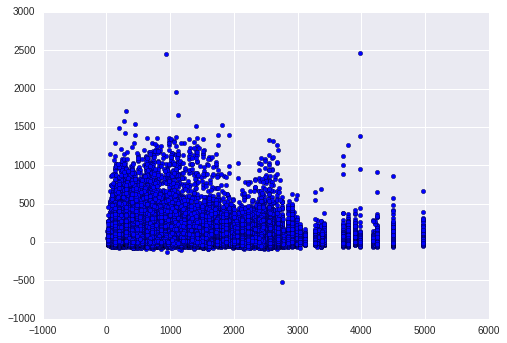

In [13]:
plt.scatter(data.Distance,data.ArrDelay)

In [14]:
airports = airports[['airport','city','lat','long']].set_index('city').to_dict()

In [15]:
data["origin_lat"] = data["origin_city"].map(airports['lat'])
data["origin_long"] = data["origin_city"].map(airports['long'])
data["destin_lat"] = data["destin_city"].map(airports['lat'])
data["destin_long"] = data["destin_city"].map(airports['long'])

In [16]:
# Trips
trips = data.groupby(['origin_city','destin_city'])[['UniqueCarrier']].count().reset_index()
trips.columns = ['origin_city','destin_city','Count']

In [17]:
trips.head()

origin_city destin_city  Count
0      Abilene      Dallas   2660
1  Adak Island   Anchorage    102
2    Aguadilla    New York    661
3    Aguadilla      Newark    366
4    Aguadilla     Orlando    492

In [18]:
import numpy as np
data = data[data['origin_lat'].notnull()]
data = data[data['origin_long'].notnull()]
data['coord'] = zip(data['origin_long'],data['origin_lat'])
pos = data[['origin_city','coord']].dropna().set_index('origin_city').to_dict()

In [19]:
#data[data['origin_city']=='Pocatello']['coord'].tail()
print(len(data[['origin_city','coord']].dropna()))
print(len(data[['origin_city','coord']]))

6565198
6572735


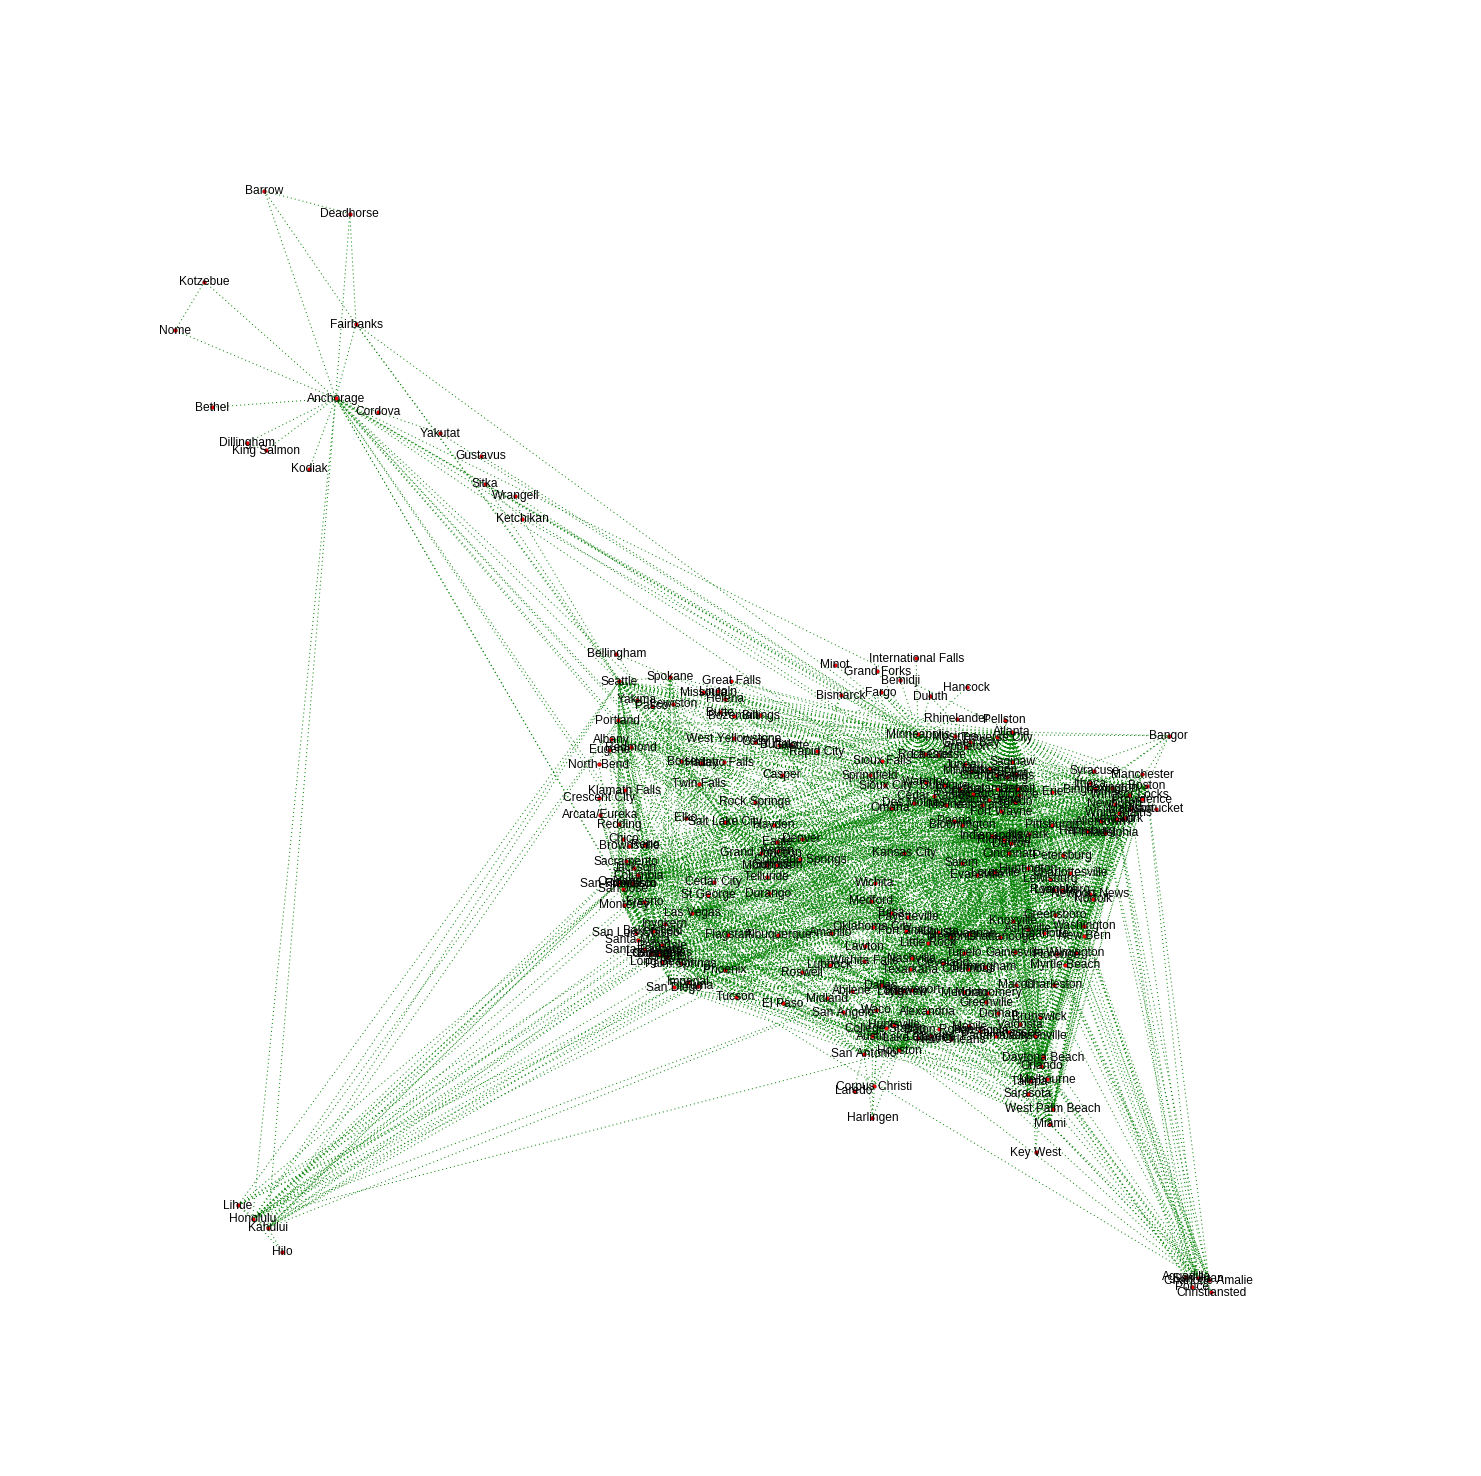

In [41]:
#create an empty undirected network
G=nx.Graph()
G.add_nodes_from(list(pd.unique(trips.origin_city.dropna())))
G.add_weighted_edges_from(zip(trips['origin_city'].dropna(),trips['destin_city'].dropna(),trips['Count'].dropna()))
#np.random.seed(2015) #fix the origin of random generator - see below why
#now let's visualize, which turns out to be fairly simple with networkx

#G.remove_nodes_from(['Keahole','Orange County','Gulfport','North Canton','Elmira / Corning','Champaign','Fort Lauderdale','Rdu Airport','Avoca','Saint Petersburg','Saint Louis','Blountville','BWI Airport','Fort Myers','Mcallen','Pocatello','South Burlington'])
G.remove_nodes_from(['Fort Hood / Killeen','Pierre','Pueblo','Ogden','Keahole','Fayetteville / Springdale','Adak Island','Egg Harbor Township','Cheyenne','Beaumont / Port Arthur','Champaign','Orange County','BWI Airport','Gulfport','South Burlington','North Canton','Elmira / Corning','Fort Lauderdale','Rdu Airport','Avoca','Saint Petersburg','Saint Louis','Blountville','Fort Myers','Mcallen','Pocatello'])
plt.figure(figsize=(20,20))
nx.draw(G,pos=pos['coord'],with_labels=True,node_size=15,style='dotted',edge_color='green')

In [42]:
d=G.degree().values()
j=np.argmax(d)
print('Most connected airport is {0} with {1} connections'.format(G.degree().keys()[j],d[j]))

Most connected airport is Atlanta with 144 connections


In [43]:
delays = delays[delays.destin_city != "Pierre"]
ar_delays  = delays.groupby(['origin_city'])['ArrDelay'].mean().reset_index()
dep_delays = delays.groupby(['destin_city'])['DepDelay'].mean().reset_index()

# one could argue it is the other way around
sizes_ar = nx.betweenness_centrality(G)
sizes_dep = sizes_ar
for names in sizes_ar.keys():
    sizes_ar[names] = float(ar_delays[ar_delays.origin_city==names]['ArrDelay'] / sizes_ar[names])
    
for names in sizes_dep.keys():
    #if names !='Pierre':
    sizes_dep[names] = float(dep_delays[dep_delays.destin_city==names]['DepDelay'] / sizes_dep[names])

In [66]:
# Save in separate csvs for prettier plotting
ar_df = pd.DataFrame([]).from_dict(sizes_ar,orient='index').reset_index()
ar_df.columns = ['origin_city','ind']
dep_df = pd.DataFrame([]).from_dict(sizes_dep,orient='index').reset_index()
dep_df.columns = ['destin_city','ind']
ar_df["origin_lat"]   = ar_df["origin_city"].map(airports['lat'])
ar_df["origin_long"]  = ar_df["origin_city"].map(airports['long'])
dep_df["destin_lat"]  = dep_df["destin_city"].map(airports['lat'])
dep_df["destin_long"] = dep_df["destin_city"].map(airports['long'])
dep_df.to_csv('Departure_vulnerability.csv')
ar_df.to_csv('Arrival_vulnerability.csv')

In [69]:
ar_df.sort('ind',ascending=False).head(10)

/home/saf537/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


origin_city       ind  origin_lat  origin_long
229       Anchorage  0.182137   61.214379  -149.846161
28          Atlanta  0.167439   45.000008   -84.133337
161  Salt Lake City  0.121132   40.619540  -111.992886
133          Dallas  0.107078   32.680861   -96.868194
56      Minneapolis  0.101947   44.880547   -93.216922
165         Chicago  0.084103   41.979595   -87.904464
94      Los Angeles  0.083590   34.259325  -118.413433
117         Seattle  0.072145   47.448982  -122.309313
78    San Francisco  0.065996   37.619002  -122.374843
74           Denver  0.062989   39.785250  -104.543139

In [70]:
dep_df.sort('ind',ascending=False).head(10)

/home/saf537/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


destin_city       ind  destin_lat  destin_long
229       Anchorage  0.182137   61.214379  -149.846161
28          Atlanta  0.167439   45.000008   -84.133337
161  Salt Lake City  0.121132   40.619540  -111.992886
133          Dallas  0.107078   32.680861   -96.868194
56      Minneapolis  0.101947   44.880547   -93.216922
165         Chicago  0.084103   41.979595   -87.904464
94      Los Angeles  0.083590   34.259325  -118.413433
117         Seattle  0.072145   47.448982  -122.309313
78    San Francisco  0.065996   37.619002  -122.374843
74           Denver  0.062989   39.785250  -104.543139

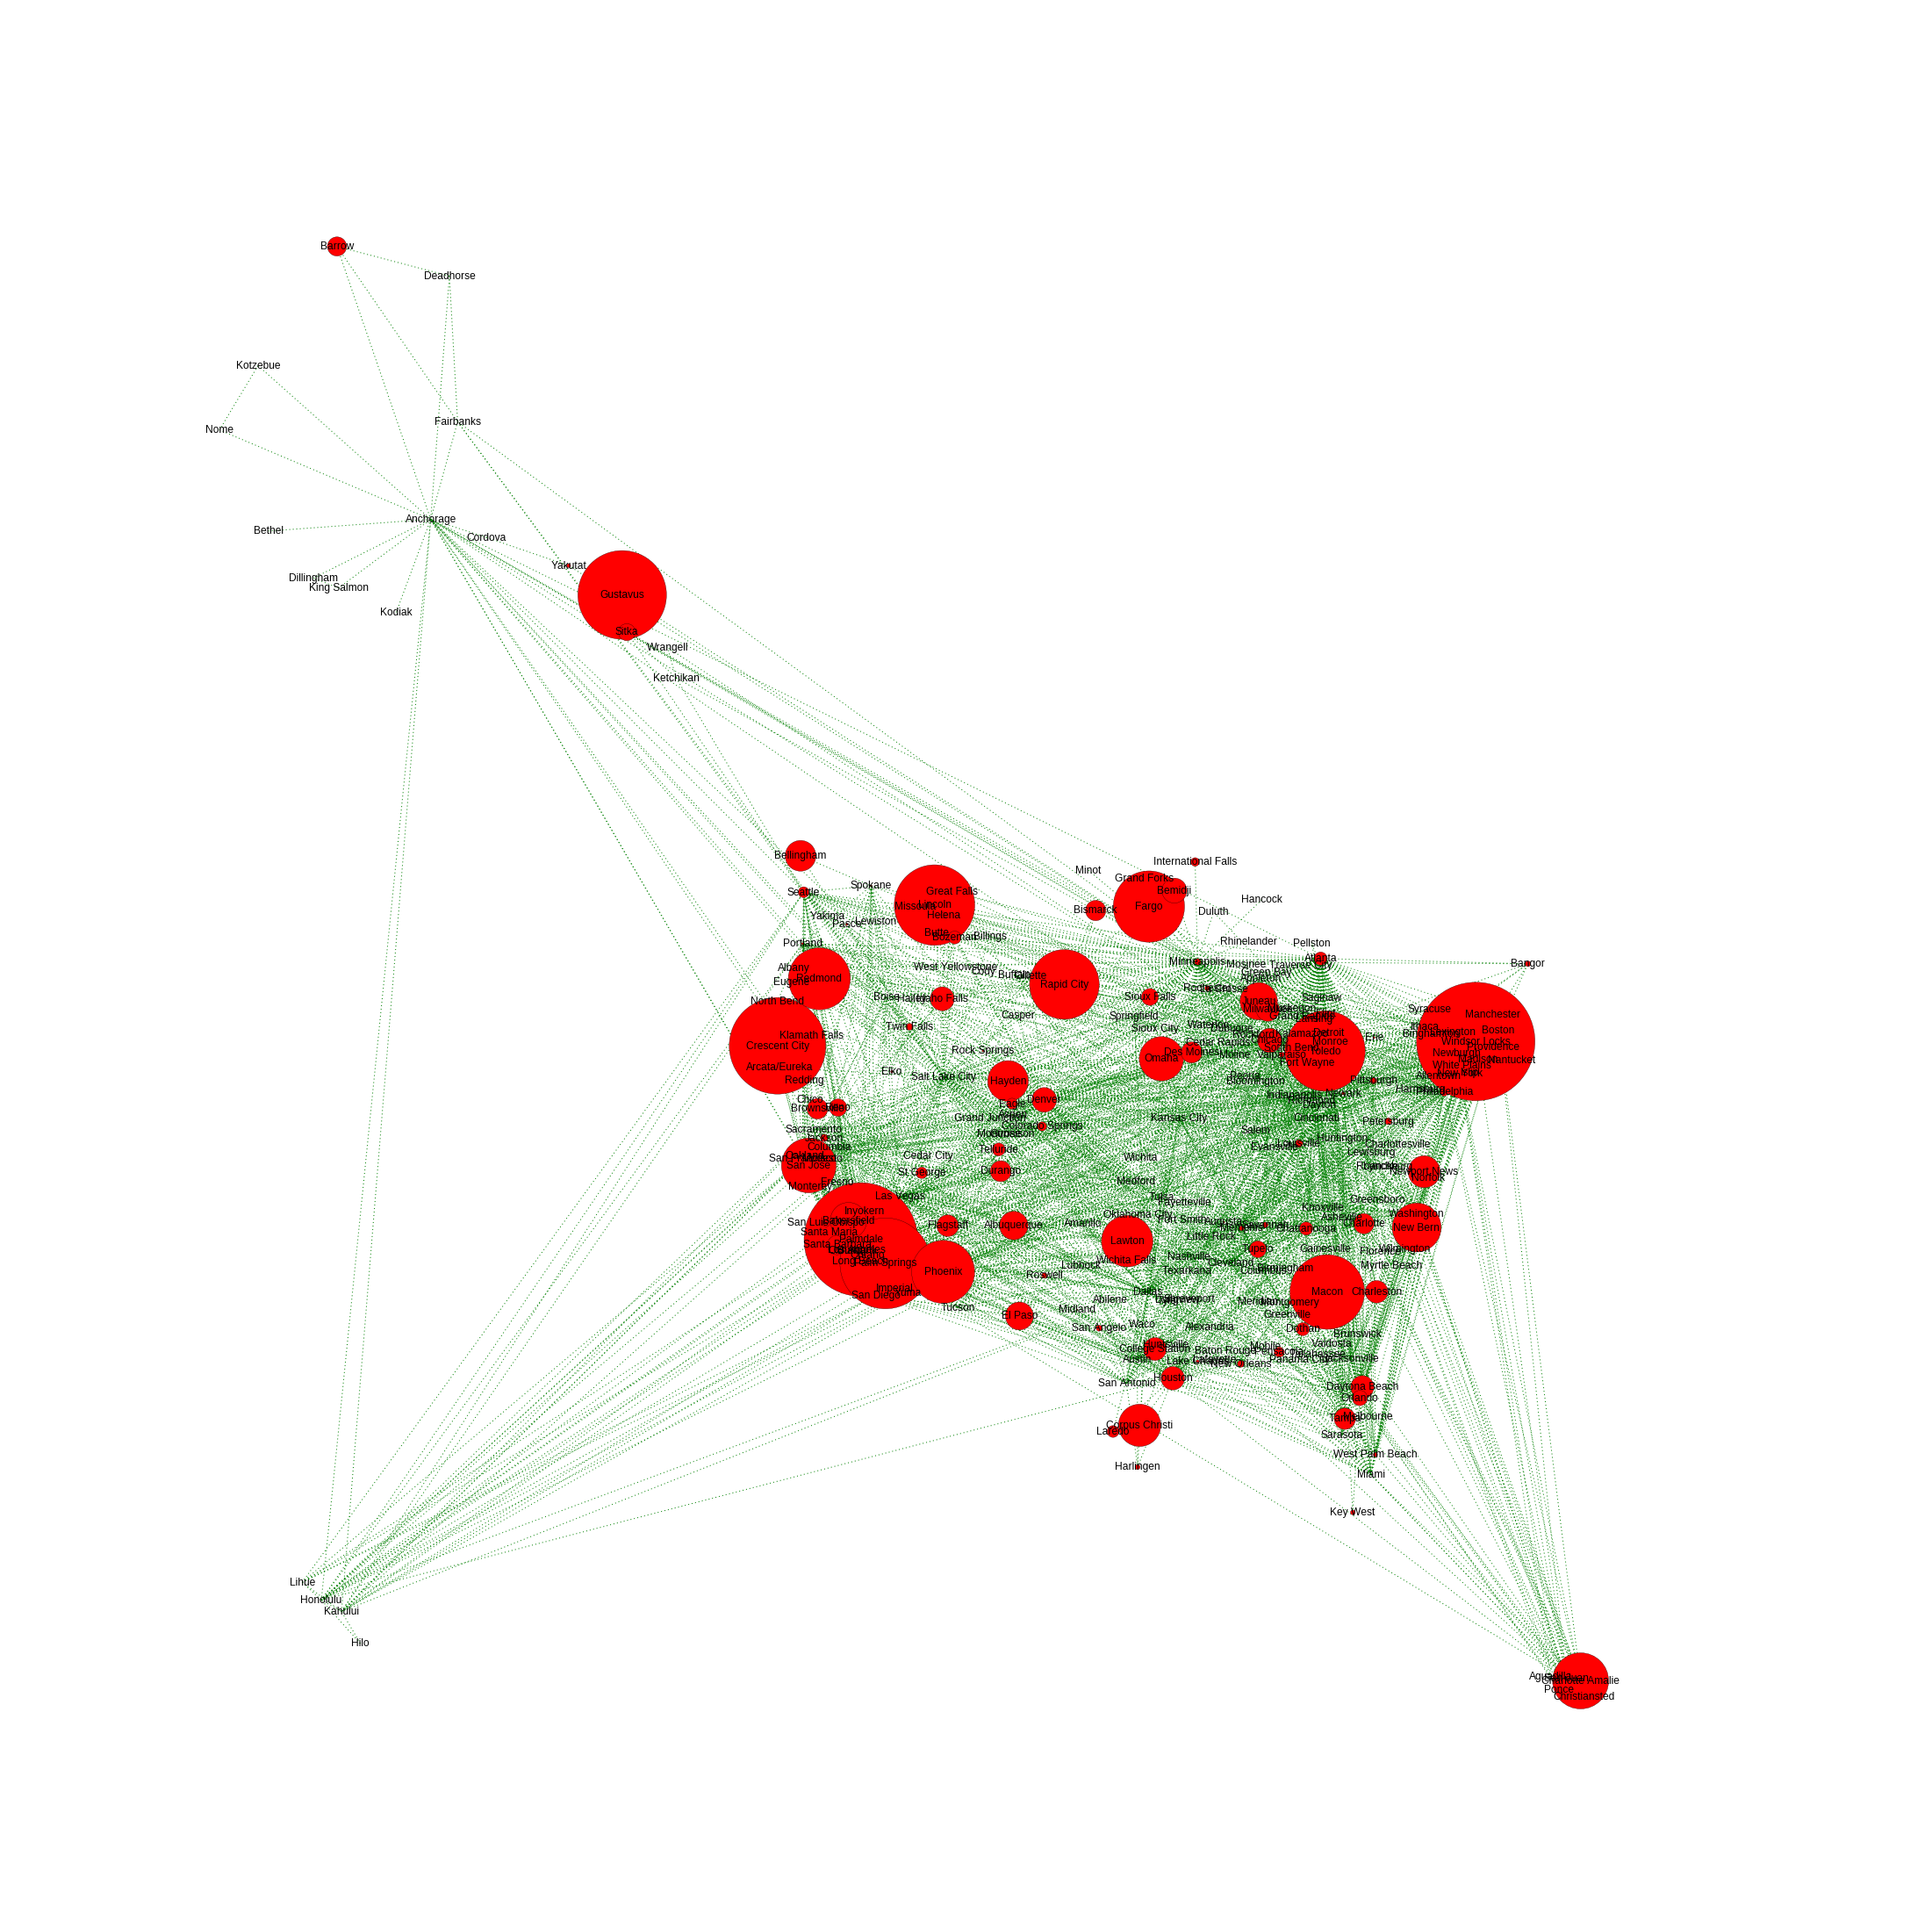

In [46]:
plt.figure(figsize=(30,30))
nx.draw(G,pos=pos['coord'],with_labels=True,
        node_size=10000E1*np.array(sizes_dep.values()),style='dotted',edge_color='green')

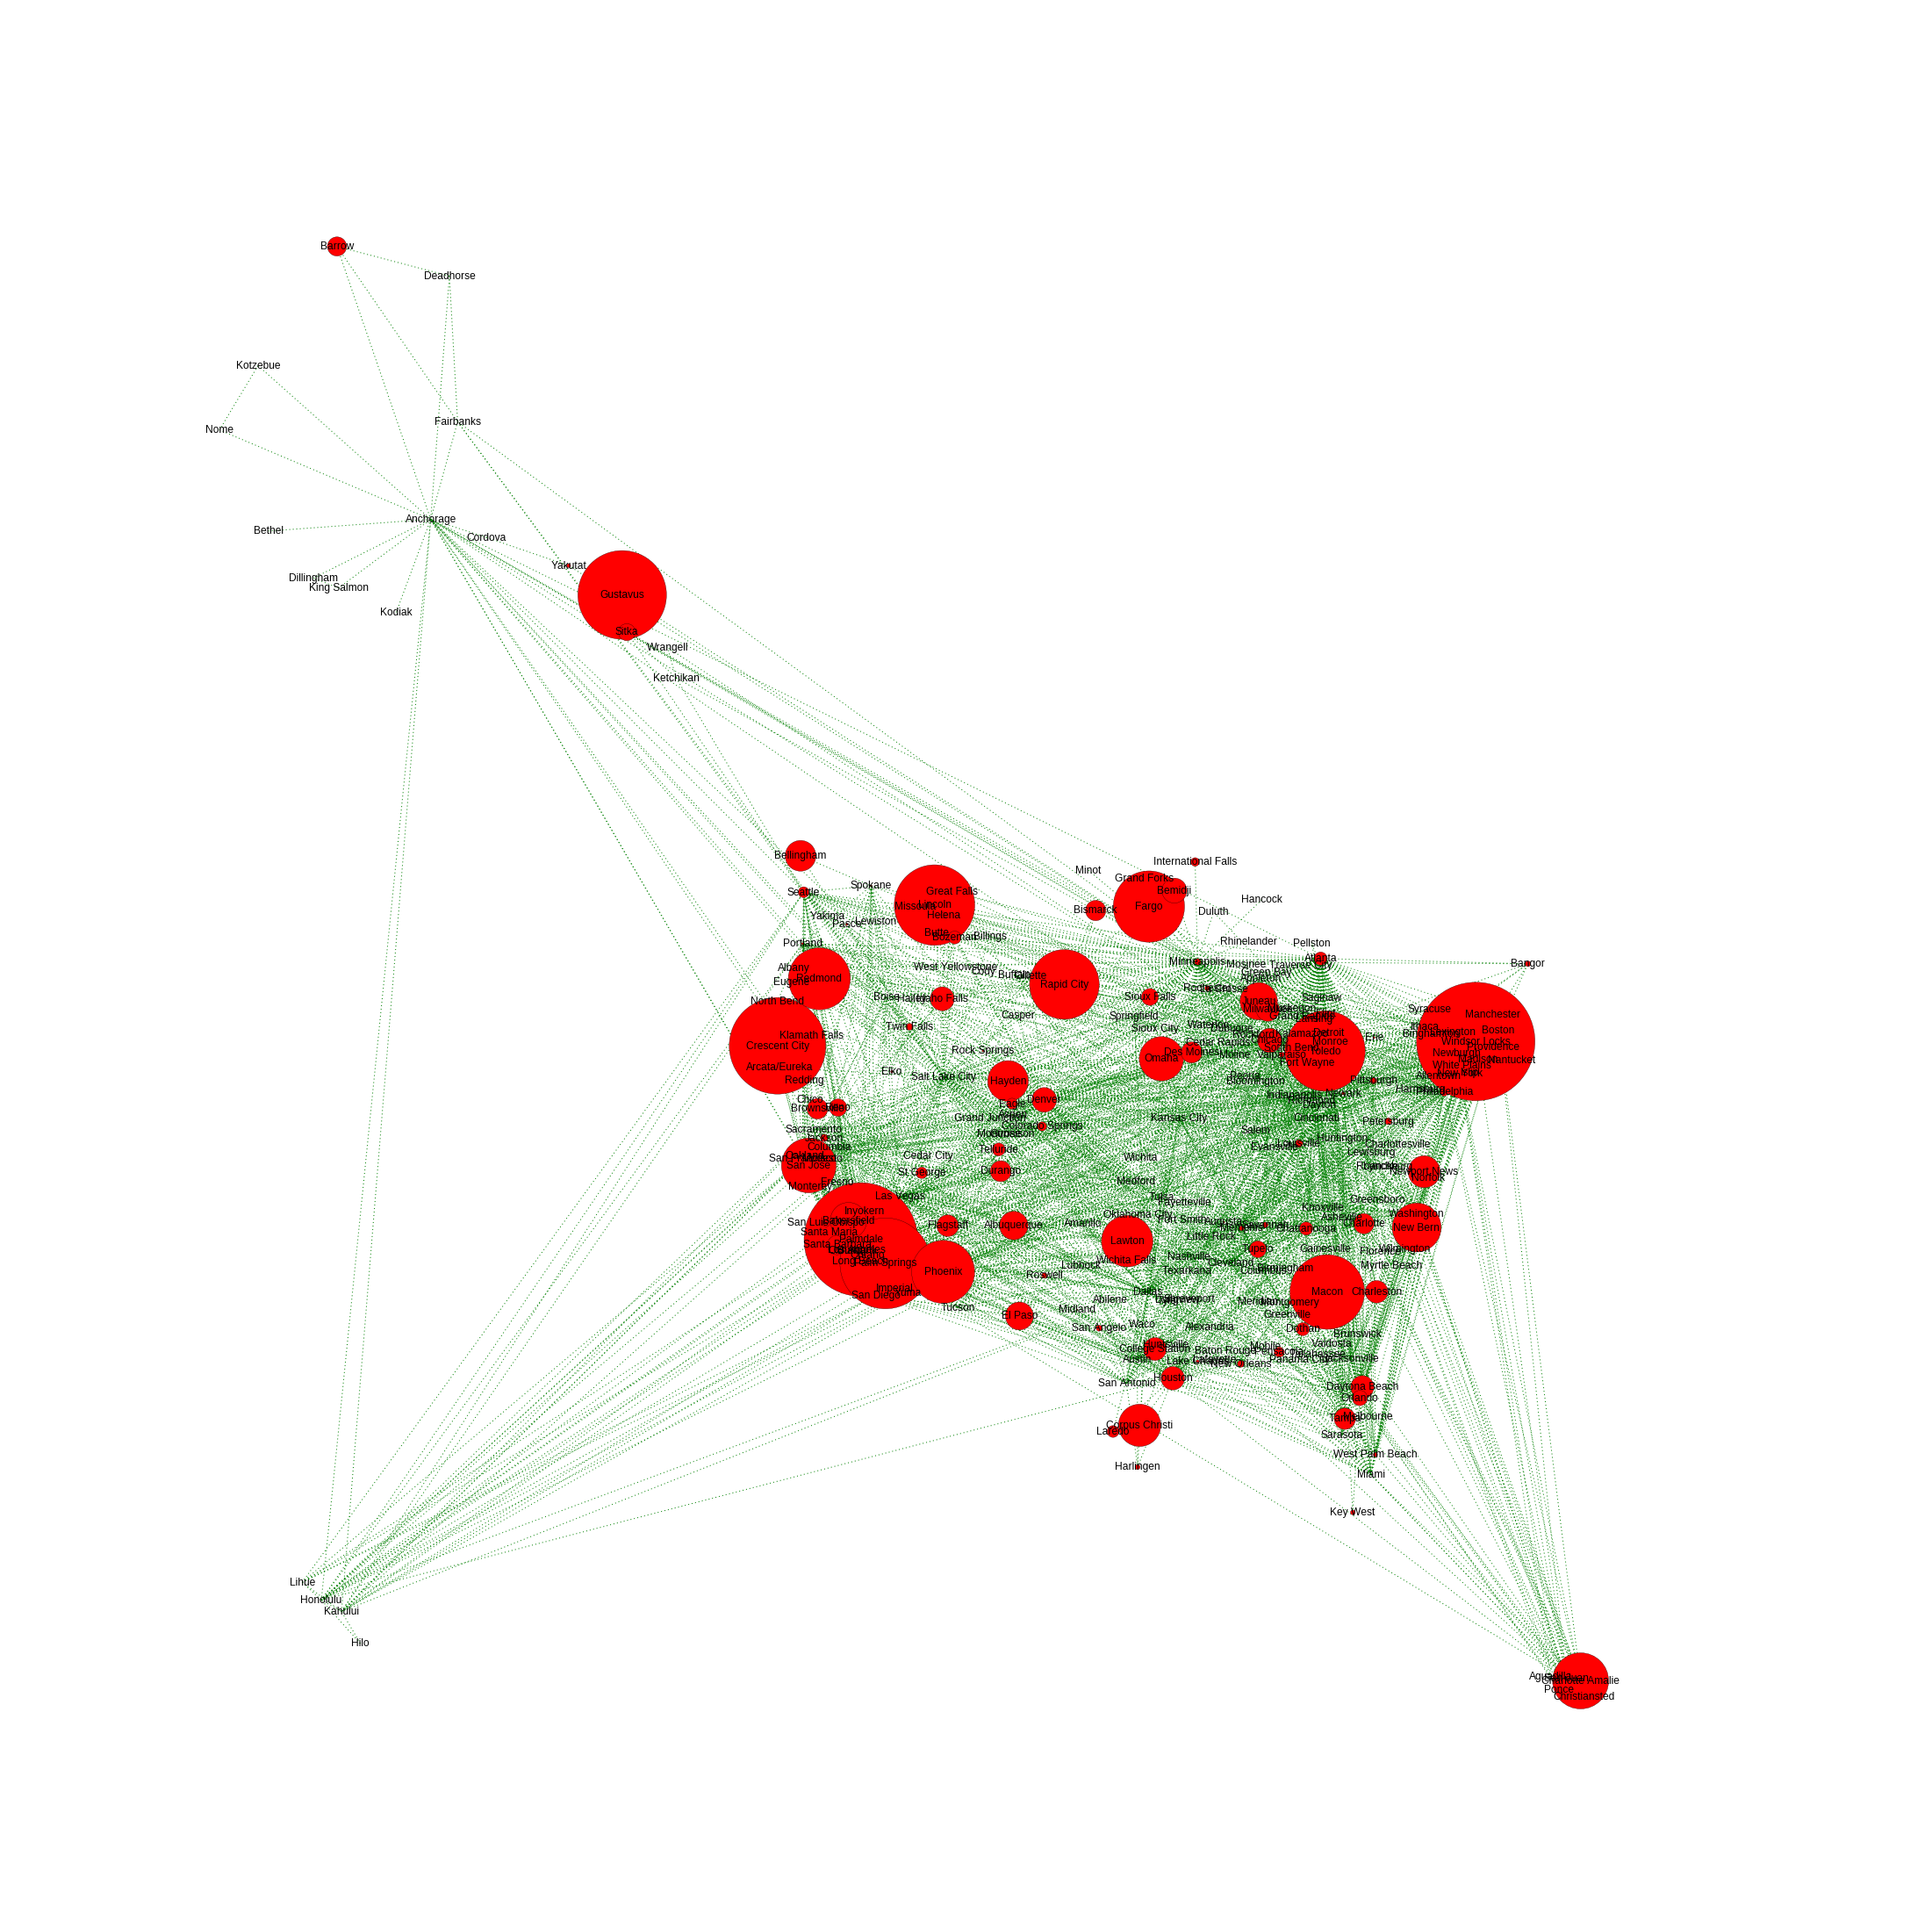

In [56]:
plt.figure(figsize=(30,30))
nx.draw(G,pos=pos['coord'],with_labels=True,
        node_size=10000E1*np.array(sizes_ar.values()),style='dotted',edge_color='green')

In [57]:
data = data[[ u'ActualElapsedTime','UniqueCarrier' ,u'CRSElapsedTime','CarrierDelay', u'origin_city', u'destin_city',u'origin_lat', u'origin_long', u'destin_lat', u'destin_long', u'coord']]
data.head()

ActualElapsedTime UniqueCarrier  CRSElapsedTime  CarrierDelay  \
0              128.0            WN           150.0           NaN   
1              128.0            WN           145.0           NaN   
2               96.0            WN            90.0           NaN   
3               88.0            WN            90.0           NaN   
4               90.0            WN            90.0           2.0   

    origin_city  destin_city  origin_lat  origin_long  destin_lat  \
0    Washington        Tampa   35.570468   -77.049813   28.013984   
1    Washington        Tampa   35.570468   -77.049813   28.013984   
2  Indianapolis  BWI Airport   39.935203   -86.044953         NaN   
3  Indianapolis  BWI Airport   39.935203   -86.044953         NaN   
4  Indianapolis  BWI Airport   39.935203   -86.044953         NaN   

   destin_long                        coord  
0   -82.345279  (-77.04981306, 35.57046806)  
1   -82.345279  (-77.04981306, 35.57046806)  
2          NaN   (-86.04495333, 39.9352025)  
3          NaN   (-86.04495333, 39.9352025)  
4          NaN   (-86.04495333, 39.9352025)

In [58]:
import os
lst = []
path = 'Data/trips/'
test = pd.DataFrame([])
for name in os.listdir(path):
    df = pd.read_csv(path+name,usecols=[u'ActualElapsedTime',u'CRSElapsedTime', u'Origin', u'Dest','Year','ArrDelay','DepDelay'])
    df['CRSElapsedTime'+str(df.Year[0])] =  df['CRSElapsedTime']
    df['TotDelay'+str(df.Year[0])] =  df['ArrDelay'] + df['DepDelay']
    df = df.groupby(['Origin','Dest'])[['CRSElapsedTime'+str(df.Year[0]),'TotDelay'+str(df.Year[0])]].mean()
    lst.append(df)
    del(df)


In [ ]:
df.col

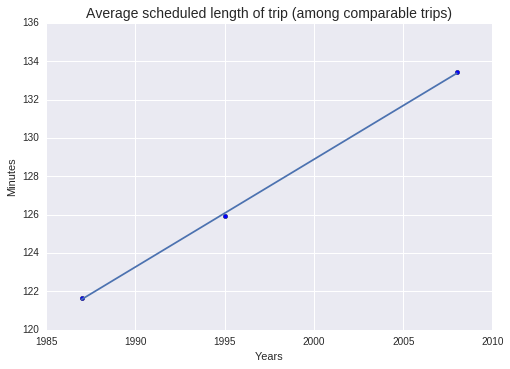

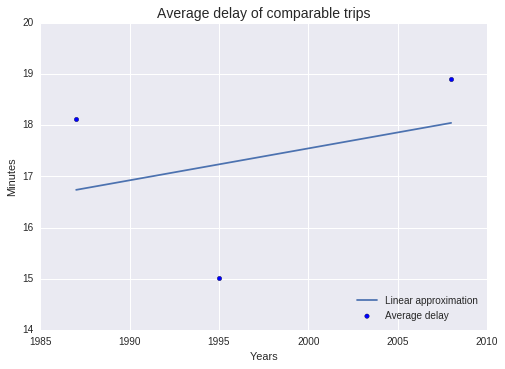

In [78]:
df    = pd.concat(lst, axis=1, join_axes=[lst[0].index]).dropna()
from scipy import stats

sched_cols = [col for col in list(df) if col.startswith('CRS')]
delay_cols = [col for col in list(df) if col.startswith('TotDelay')]
years = np.array([int(i[-4:]) for i in sched_cols])
average_length = np.array(df[sched_cols].mean())
average_delay = np.array(df[delay_cols].mean())
slope, intercept, r_value, p_value, std_err = stats.linregress(years,average_length)

plt.figure()
plt.title('Average scheduled length of trip (among comparable trips)',fontsize=14)
plt.xlabel('Years')
plt.ylabel('Minutes')
plt.scatter(years,average_length)
plt.plot(years,years*slope+intercept)
plt.show()

slope, intercept, r_value, p_value, std_err = stats.linregress(years,average_delay)
plt.figure()
plt.title('Average delay of comparable trips',fontsize=14)
plt.xlabel('Years')
plt.ylabel('Minutes')
plt.scatter(years,average_delay,label='Average delay')
plt.plot(years,years*slope+intercept,label = 'Linear approximation')   
plt.legend(loc=4)
plt.show()

#df['slope'] = 
#df['fit'] = 
#df['significance'] = 
#df.groupby(['Dest','Origin']).count()
#df.head()